# Analysing credit scoring data

In [12]:
import pandas as pd
import scipy.stats as ss
import scipy
import numpy as np
import matplotlib.pyplot as plot
import seaborn

In [2]:
df = pd.read_csv('credit_card_default_analysis.csv', header=0)

In [3]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


LIMIT_BAL: credit limit value

SEX: sex (1 = male, 2 = female )


EDUCATION: education (0 = PhD, 1 = master; 2 = bachelor; 3 = school graduated; 4 = primary school
; 5 = other; 6 = no data )


MARRIAGE: (0 = refused anser; 1 = married; 2 = not married; 3 = no data).

AGE: age (in years)

PAY_0 - PAY_6 : History of paying credit. PAY_6 - paid in April, ... Pay_0 - paid in September. Pay = (0 = good payment, 1=1 month debt, 2=2 months debt ...)

BILL_AMT1 - BILL_AMT6: debt amount, BILL_AMT6 - on April, BILL_AMT1 - on September

PAY_AMT1 - PAY_AMT6: amount of payment in PAY_AMT6 - April, ..., PAY_AMT1 - September

default - debt's indicator (0 = no debt, 1 = debt)

## 1. Comparing amount of credit limits of people who paid the credit and debtors 

Let's separate people who got the credit back and debtors

In [4]:
payers = df[df['default'] == 0]
payers.drop('default', axis=1, inplace=True)
debtors = df[df['default'] == 1]
debtors.drop('default', axis=1, inplace=True)

C:\Users\Aqice\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


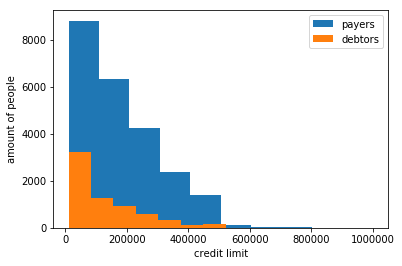

In [5]:
plot.hist(payers['LIMIT_BAL'], label='payers')
plot.hist(debtors['LIMIT_BAL'], label='debtors')
plot.xlabel('credit limit')
plot.ylabel('amount of people')
plot.legend(loc='upper right')

Let's use median ttest for 1 sample in comparing with median value

H0: LIMIT_BAL's median is the median of all the samples

H1: median is different

In [6]:
from statsmodels.stats.weightstats import zconfint
med = np.median(df['LIMIT_BAL'])
print('median value = {}'.format(med))
print('p (payers) = {}'.format(ss.ttest_1samp(payers['LIMIT_BAL'], med).pvalue))
print('p (debtors) = {}'.format(ss.ttest_1samp(debtors['LIMIT_BAL'], med).pvalue))
print('conf interval for payers:', zconfint(payers['LIMIT_BAL']))
print('conf interval for debtors:', zconfint(debtors['LIMIT_BAL']))

median value = 140000.0
p (payers) = 0.0
p (debtors) = 3.171253847551615e-12
conf interval for payers: (176411.91449742022, 179787.53765118445)
conf interval for debtors: (127333.65333983443, 132885.65949922524)


=> H0 = H1 (for payers and debtors)

H0: debtros' LIMIT_BAL and payers' LIMIT_BAL have the same distribution

H1: the distributions are different

In [145]:
print('p (Mann Whitneyu criteria) = ', ss.mannwhitneyu(payers['LIMIT_BAL'], debtors['LIMIT_BAL']).pvalue)

p (Mann Whitneyu criteria) =  6.12774290911e-190


=> H0 = H1 (the distributions are different)

## 2. Comparing men and women in paying credits

In [7]:
male = df[df['SEX'] == 1]
male.drop('SEX', axis=1, inplace=True)
female = df[df['SEX'] == 2]
female.drop('SEX', axis=1, inplace=True)

C:\Users\Aqice\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


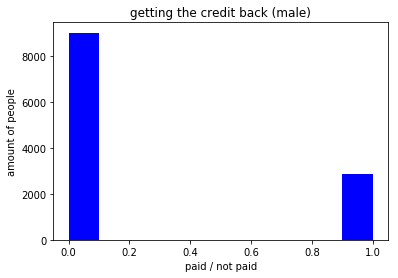

In [8]:
plot.hist(male['default'], label='male', color='blue')
plot.title('getting the credit back (male)')
plot.xlabel('paid / not paid')
plot.ylabel('amount of people')
plot.show()

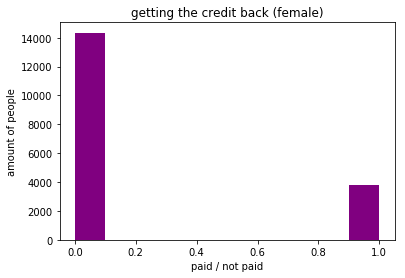

In [148]:
plot.hist(female['default'], label='female', color='purple')
plot.title('getting the credit back (female)')
plot.xlabel('paid / not paid')
plot.ylabel('amount of people')
plot.show()

Let's try to use conf intervals to see if there is a difference between males and females paying credits

In [149]:
from statsmodels.stats.proportion import proportion_confint
conf_int_male = proportion_confint(sum(male['default']), male.shape[0], method='normal')
conf_int_female = proportion_confint(sum(female['default']), female.shape[0], method='normal')
print('conf interval for males: {}'.format(conf_int_male))
print('conf interval for females: {}'.format(conf_int_female))

conf interval for males: (0.23397679702375163, 0.2493677521014166)
conf interval for females: (0.20185432056295824, 0.21367129781160007)


As we can see, the intervals don't intersect

Let's use p-value for difference of 2 samples

In [150]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative='two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

H0: males and females pay credits equally

H1: males and females pay credits not equally

In [151]:
print("p-value: {}".format(proportions_diff_z_test(proportions_diff_z_stat_ind(male['default'], female['default']))))

p-value: 4.472866521609831e-12


We've got a very small p-value. That means that H0 = H1. Let's see what sex pays credits better

In [152]:
print('paid/not paid (male): {}'.format(male[male['default'] == 0].shape[0] / male[male['default'] == 1].shape[0]))
print('paid/not paid (female): {}'.format(female[female['default'] == 0].shape[0] / female[female['default'] == 1].shape[0]))

paid/not paid (male): 3.13783501566307
paid/not paid (female): 3.813180972628222


Well, it seems like women pay credits better. So fine

## 3. Comparing educational affect on paying credits

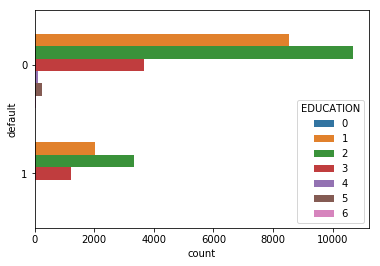

In [17]:
seaborn.countplot(y='default', data=df, hue='EDUCATION')

In [9]:
educ_def_table = []
for i in range(7):
    educ_def_table.append([df[df['EDUCATION'] == i][df['default'] == 0].shape[0],
                          df[df['EDUCATION'] == i][df['default'] == 1].shape[0]])

C:\Users\Aqice\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Aqice\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\Aqice\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Aqice\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\Aqice\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykerne

In [155]:
sum_amount = []
for i in educ_def_table:
    sum_amount.append(sum(i))

Let's use chi-square test to find middle values of amounts of people with different education paying credits 

In [156]:
from scipy.stats import chi2_contingency
middledata, p = chi2_contingency(educ_def_table)[3], chi2_contingency(educ_def_table)[1]
educ_def_table -= middledata
table_list = np.array(educ_def_table)

In [157]:
for i in range(len(table_list)):
    table_list[i] = table_list[i] / sum_amount[i]

In [158]:
educ_def_table = pd.DataFrame(table_list)
educ_def_table.rename(columns={0: 'paid', 1: 'not paid'}, inplace=True)
educ_def_table.rename({0: '0 (PhD)', 1: '1 (master)', 2: '2 (bachelor)', 
                       3: '3 (high school)', 4: '4 (primary school)', 5: '5 (other)', 6: '6 (no data)'},
                      axis='index',
                      inplace=True)

In [159]:
educ_def_table

,paid,not paid
0 (PhD),0.221200,-0.221200
1 (master),0.028852,-0.028852
2 (bachelor),-0.016149,0.016149
3 (high school),-0.030376,0.030376
4 (primary school),0.164289,-0.164289
5 (other),0.156914,-0.156914
6 (no data),0.064337,-0.064337


H0: education doesn't affect on paying credits

H1: education affects of paying credits

In [160]:
print('with p value = {} we can reject H0'.format(p))

with p value = 1.2332626245415605e-32 we can reject H0


Clients with PhD pay credits better than others

Clients with bachelor degree and high school education more often have depts with their credits

## 4. Comparing marriage affect on paying credits

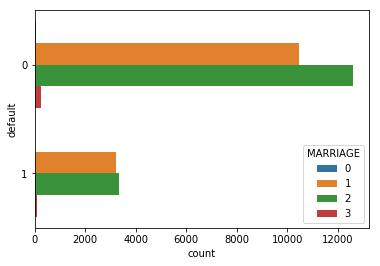

In [18]:
seaborn.countplot(y='default', data=df, hue='MARRIAGE')

Let's use the same method as in the previous problem to see if there is an affect of marriage on paying credits

In [161]:
marr_def_table = []
for i in range(4):
    marr_def_table.append([df[df['MARRIAGE'] == i][df['default'] == 0].shape[0],
                          df[df['MARRIAGE'] == i][df['default'] == 1].shape[0]])
sum_amount_marr = []
for i in marr_def_table:
    sum_amount_marr.append(sum(i))

C:\Users\Aqice\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Aqice\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\Aqice\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Aqice\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\Aqice\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykerne

In [162]:
middledata_marr, p_marr = chi2_contingency(marr_def_table)[3], chi2_contingency(marr_def_table)[1]
marr_def_table -= middledata_marr
table_list_marr = np.array(marr_def_table)

In [163]:
for i in range(len(table_list_marr)):
    table_list_marr[i] = table_list_marr[i] / sum_amount[i]

In [164]:
marr_def_table = pd.DataFrame(table_list_marr)
marr_def_table.rename(columns={0: 'paid', 1: 'not paid'}, inplace=True)
marr_def_table.rename({0: '0 (answer refused)', 1: '1 (married)', 2: '2 (not married)', 3: '3 (no data)'},
                      axis='index', inplace=True)

In [165]:
marr_def_table

,paid,not paid
0 (answer refused),0.496057,-0.496057
1 (married),-0.017443,0.017443
2 (not married),0.013559,-0.013559
3 (no data),-0.002553,0.002553


H0: marriage doesn't affect on paying credits

H1: marriage affects of paying credits

In [166]:
print('with p value = {} we can reject H0'.format(p_marr))

with p value = 8.825862457577375e-08 we can reject H0


Clients who refused to answer about their marriage status pay credits better than others

Married clients and clients with unknown marriage status pay credits a bit worse than other

Let's use V-Cramer statistics to see if there is a correlation between marriage status and default column

In [19]:
def cramers_stat(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

In [21]:
marr_def_table_cramer = []
for i in range(4):
    marr_def_table_cramer.append([df[df['MARRIAGE'] == i][df['default'] == 0].shape[0],
                          df[df['MARRIAGE'] == i][df['default'] == 1].shape[0]])

C:\Users\Aqice\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Aqice\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\Aqice\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Aqice\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\Aqice\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykerne

In [26]:
print('V-Cramer value: {}'.format(cramers_stat(np.array(marr_def_table_cramer))))

V-Cramer value: 0.034478203662766466


There's a small correlation between marriage status and paying credits

## 5. Comparing age distributions of people who paid the credit and debtors

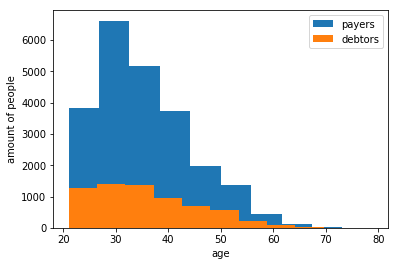

In [169]:
plot.hist(payers['AGE'], label='payers')
plot.hist(debtors['AGE'], label='debtors')
plot.xlabel('age')
plot.ylabel('amount of people')
plot.legend(loc='upper right')

On histogram we can see that distributions look a bit similar

In [170]:
med_age = np.median(df['AGE'])
print('median value = {}'.format(med_age))
print('p (payers) = {}'.format(ss.ttest_1samp(payers['AGE'], med_age).pvalue))
print('p (debtors) = {}'.format(ss.ttest_1samp(debtors['AGE'], med_age).pvalue))
print('conf interval for payers:', zconfint(payers['AGE']))
print('conf interval for debtors:', zconfint(debtors['AGE']))

median value = 34.0
p (payers) = 2.167927189851743e-124
p (debtors) = 6.048724679210506e-47
conf interval for payers: (35.300871020374075, 35.533660737886493)
conf interval for debtors: (35.492514653706728, 35.958962139542216)


Conf intervals intersect. Let's check Mann Whitneyu criteria 

H0: Middle age of payers and debtors are the same

H1: Middle age of payers and debtors are different

In [171]:
print('p (Mann Whitneyu criteria) = {}'.format(ss.mannwhitneyu(payers['AGE'], debtors['AGE']).pvalue))

p (Mann Whitneyu criteria) = 0.1862517717449308


We can't reject H0.

Paying or not paying credit doesn't affect on age of a client